In [3]:
input_cardinality=20
output_cardinality=1

In [4]:
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import sklearn.model_selection as sk
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [5]:
#import pytorch_lightning as pl
import time
import copy
from tqdm import tqdm


In [6]:
torch.manual_seed(0)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [7]:
#from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
#from pytorch_lightning.loggers import TensorBoardLogger

In [8]:
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

In [9]:
#pl.seed_everything(43)

In [10]:
class DATA:
    def __init__(self, data_path):
        self.data_path = data_path
        self.filenames = os.listdir(DATA_PATH)
        self.filenames = [filename for filename in self.filenames if filename.endswith(".csv")]
        self.len_filenames = len(self.filenames)
        
    def get_data(self):
        self.data = []
        for i in range(len(self.filenames)):
            self.data.append(self.read_data(i))
        return self.data
    
    def read_data(self,i):
        return pd.read_csv(self.data_path+"/"+self.filenames[i])
    

    def process_data(self, scaler, input_cardinality=20, output_cardinality=10, cols=['ThetaXHG']):
        self.datasamples = self.get_data()
        X = []
        y = []
        X_scaled = []
        y_scaled = []
        for i, datasample in enumerate(self.datasamples):            
            #for j in range(datasample[cols].shape[0]-output_cardinality):
            #    print('Input' +str(j)+ ' to '+str(j+input_cardinality) + 'Output: '+str(j+input_cardinality)+ ' to '+str(j+input_cardinality+output_cardinality))
            #Append to X (TO MAKE A LIST OF LISTS), [[0.019,1.02,...., upto input_cardinality]]
            #Append to Y (TO MAKE A LIST OF LISTS), [[0.019,1.02,...., upto output_cardinality]]
            #start of Y will be ahead of end of X by 1
            
            for j in range(datasample.shape[0]-output_cardinality-input_cardinality+1):
                X.append(datasample[cols].iloc[j:j+input_cardinality].to_numpy())
                y.append(datasample[cols].iloc[j+input_cardinality: j+input_cardinality+output_cardinality].to_numpy())
                X_scaled.append(scaler.transform(datasample[cols].iloc[j:j+input_cardinality].to_numpy()))
                y_scaled.append(scaler.transform(datasample[cols].iloc[j+input_cardinality: j+input_cardinality+output_cardinality].to_numpy()))
        
        #return self.datasamples, X, y
        #print(np.array(X).shape,np.array(y).shape,np.array(X_scaled).shape, np.array(y_scaled).shape)
        return self.datasamples, np.array(X), np.array(y), np.array(X_scaled), np.array(y_scaled)
    
    
    def train_test_split(self, X, y, split={'train':0.8,'val':0.2, 'test':0.5}):
        #print(X)
        self.X_train, self.X_val_test, self.y_train, self.y_val_test = sk.train_test_split(X, y, test_size=split['val'] , random_state=43)
        self.X_test, self.X_val, self.y_test, self.y_val = sk.train_test_split(self.X_val_test, self.y_val_test, test_size=split['test'] , random_state=43)
        
        return (self.X_train, self.y_train), (self.X_val, self.X_test), (self.X_test, self.y_test)
    
    
    
    def getscaler(self,cols):
        self.datasamples = self.get_data()       
        for i, sample in enumerate(self.datasamples):
            if i ==0:
                features = pd.DataFrame(sample[cols])
            else:
                features = pd.DataFrame.append(features, sample[cols]) #sample[cols]
   
        #scaling
        scaler = MinMaxScaler(feature_range=(-1,1))
        scaler = scaler.fit(features)
        features_scaled = pd.DataFrame(scaler.transform(features), index = features.index, columns = cols)
        return scaler
    
        """        
        #convert back to datasamples
        #save to X
        #save to X_scaled
        
        
        #Split treain test and validation
        
        for i in range(features.shape[0]):
            self.datasamples = []
            
        
        
        
        return features, features_scaled
        """
        
        

In [11]:
class THETADATASET(Dataset):
    #convert to pytorch dataset
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        sequence, output = self.X[idx], self.y[idx]
        return (torch.from_numpy(sequence.reshape(-1)), torch.from_numpy(output.reshape(-1)))
        #return dict(sequence=torch.tensor(sequence.reshape(-1),dtype=torch.float64), label=torch.tensor(output.reshape(-1),dtype=torch.float64))

In [12]:
class THETADATASETLOADER():
    def __init__(self, data, batchsize, bs_val):
        super().__init__()
        self.data = data
        self.batchsize = batchsize
        self.train_dataset = THETADATASET(self.data.X_train, self.data.y_train)
        self.val_dataset = THETADATASET(self.data.X_val, self.data.y_val)
        self.test_dataset = THETADATASET(self.data.X_test, self.data.y_test)
        self.train_dataloader = DataLoader(self.train_dataset, batch_size = self.batchsize, shuffle= False, num_workers=0, worker_init_fn=seed_worker,generator=g)
        self.val_dataloader = DataLoader(self.val_dataset, batch_size = bs_val, shuffle= False, num_workers=0,  worker_init_fn=seed_worker,generator=g)
        self.test_dataloader = DataLoader(self.test_dataset, batch_size = 1, shuffle= False, num_workers=0,  worker_init_fn=seed_worker,generator=g)

In [13]:
#dataloaders={}
#dataloaders['train'], dataloaders['val'] = data_loaded.train_dataloader, data_loaded.val_dataloader

In [14]:
"""
for f, o in tqdm(dataloaders['train']):
    #print(f[0].shape)
    break
"""

"\nfor f, o in tqdm(dataloaders['train']):\n    #print(f[0].shape)\n    break\n"

In [15]:
#loss_fn(a,first['label'])

In [16]:
#X_test.shape

In [17]:
def train_model(DATA_LOADED, model, criterion, optimizer, num_epochs=25):
    #train_model(DATA_LOADED, model, criterion, optimizer, scheduler, num_epochs=25):
    start = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 0
    dataloaders ={}
    dataloaders['train'], dataloaders['val'] = DATA_LOADED.train_dataloader, DATA_LOADED.val_dataloader

    #TR_ACCURACY=[]
    TR_LOSS=[]
    #VAL_ACCURACY=[]
    VAL_LOSS=[]
    for epoch in range(num_epochs):
        model.reset_hidden_states()
        #model.reset_hidden_states()
        #print(model.hidden)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            #running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    #_, preds = torch.max(outputs, 1)
                # backward + optimize only if in training phase
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                #running_corrects += torch.sum(preds == labels.data)

            #if phase == 'train':
            #    scheduler.step()

            #epoch_loss = running_loss / DATA_LOADED.dataset_sizes[phase]
            epoch_loss = running_loss / dataset_size[phase]
            
            #epoch_acc = running_corrects.double() / DATA.dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            

            if phase == 'train':
                #  print("Training")
                #  TR_ACCURACY.append(epoch_acc)
                TR_LOSS.append(epoch_loss)
            else:
                print("Valuation")
                #VAL_ACCURACY.append(epoch_acc)
                VAL_LOSS.append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    #print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return TR_LOSS, VAL_LOSS, model




In [18]:
class CHALLEABLELSTMNET(nn.Module):
    def __init__(self, batch_size, input_len, output_len, lstm_units = 4, num_layers=1):
        super(LSTMNET, self).__init__()
        self.input_len = input_len
        self.output_len = output_len
        self.num_layers = num_layers
        self.batch_size = batch_size
        #input_size = no of features = 1
        #hidden_size = no of lstm units in the layer
        #num_layers = no of lstm layers
        self.lstm_units = lstm_units
        self.lstm1 = nn.LSTM(input_size= 1, hidden_size= lstm_units, num_layers=num_layers,batch_first=True, dropout=0.6)
        
        self.linear0 = nn.Linear(in_features= 20, out_features=10)
        
        self.linear1 = nn.Linear(in_features= lstm_units, out_features=10)
        self.linear2 = nn.Linear(in_features= 10, out_features=10)
        self.ll = nn.Linear(in_features= 10, out_features=output_len)
        self.hidden = (torch.zeros(1*self.num_layers, self.batch_size, self.lstm_units).to(device).double(), torch.zeros(1*self.num_layers, self.batch_size, self.lstm_units).to(device).double())
        #print(self.hidden[0].device)
        #print(self.hidden.shape)
        #self.hidden[0]= self.hidden[0].to(device)
        #self.hidden[1] = self.hidden[1].to(device)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
    def reset_hidden_states(self):
        self.hidden = (torch.zeros(1*self.num_layers, self.batch_size, self.lstm_units).double(), torch.zeros(1*self.num_layers, self.batch_size, self.lstm_units).double())
    def forward(self,x):
        #print(x.shape)
        #print(x)
        #print(x.unsqueeze(-1).shape)
        #print(self.hidden.shape)
        #print(self.hidden)
        #lstm_out, (h,c) = self.lstm1(x.unsqueeze(-1), self.hidden)
        #self.hidden= (h.detach(),c.detach())
        #c.detach_()
        #h.detach_()
        #self.hidden = (h.detach(), c.detach())
        #print(ht.shape)
        #ht=ht.to(device)
        #ct=ct.to(device)
        
        #lstm_out = lstm_out[:,-1,:]
        #print(ht.shape)
        #either lstm_out goes to next or ht goes
        #lstm_out= ht[-1]
        #lin1_out = self.linear1(lstm_out)
        #Add RELU
        lin0_out = F.relu(self.linear0(x))
        ll_out = self.ll(lin0_out)
        #x = self.linear0(x)
        #print(x.shape)
        
        #x = self.linear2(x)
        #Add RELU
        return ll_out

In [19]:
class LSTMNET(nn.Module):
    def __init__(self, batch_size, input_len, output_len, lstm_units = 4, num_layers=1):
        super(LSTMNET, self).__init__()
        self.input_len = input_len
        self.output_len = output_len
        self.num_layers = num_layers
        self.batch_size = batch_size
        #input_size = no of features = 1
        #hidden_size = no of lstm units in the layer
        #num_layers = no of lstm layers
        self.lstm_units = lstm_units
        self.lstm1 = nn.LSTM(input_size= 1, hidden_size= lstm_units, num_layers=num_layers,batch_first=True, dropout=0.6)
        
        self.linear0 = nn.Linear(in_features= 20, out_features=10)
        
        self.linear1 = nn.Linear(in_features= lstm_units, out_features=10)
        self.linear2 = nn.Linear(in_features= 10, out_features=10)
        self.ll = nn.Linear(in_features= 10, out_features=output_len)
        self.hidden = (torch.zeros(1*self.num_layers, self.batch_size, self.lstm_units).double(), torch.zeros(1*self.num_layers, self.batch_size, self.lstm_units).double())
        #print(self.hidden[0].device)
        #print(self.hidden.shape)
        #self.hidden[0]= self.hidden[0].to(device)
        #self.hidden[1] = self.hidden[1].to(device)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
    
    def reset_hidden_states(self,bs):
        self.hidden = (torch.zeros(1*self.num_layers, bs, self.lstm_units).double(), torch.zeros(1*self.num_layers, bs, self.lstm_units).double())
        
    def forward(self,x):
        #print(x.shape)
        #print(x)
        #print(x.unsqueeze(-1).shape)
        #print(self.hidden.shape)
        #print(self.hidden)
        lstm_out, (h,c) = self.lstm1(x.unsqueeze(-1), self.hidden)
        self.hidden= (h.detach(),c.detach())
        #c.detach_()
        #h.detach_()
        #self.hidden = (h.detach(), c.detach())
        #print(ht.shape)
        #ht=ht.to(device)
        #ct=ct.to(device)
        
        lstm_out = lstm_out[:,-1,:]
        #print(ht.shape)
        #either lstm_out goes to next or ht goes
        #lstm_out= h.detach()[-1]
        lin1_out = self.linear1(lstm_out)
        #Add RELU
        #lin0_out = F.relu(self.linear0(x))
        ll_out = self.ll(lin1_out)
        #x = self.linear0(x)
        #print(x.shape)
        
        #x = self.linear2(x)
        #Add RELU
        return ll_out

In [20]:
#X_train.shape

In [21]:
epochs=500
batch_size = 16
bs_val = 16

In [22]:
!ls

Lookahead10.ipynb  Lookahead2.ipynb  Lookahead6.ipynb  prediction.ipynb
Lookahead15.ipynb  Lookahead3.ipynb  Lookahead7.ipynb  readme.md
Lookahead1.ipynb   Lookahead4.ipynb  Lookahead8.ipynb
Lookahead20.ipynb  Lookahead5.ipynb  Lookahead9.ipynb


In [23]:
DATA_PATH = "../DATASET/TRANSORMER_DATA"
data = DATA(DATA_PATH)
cols=['ThetaXHG']
scaler = data.getscaler(cols)

In [24]:
samples, X, y, X_scaled, y_scaled = data.process_data(scaler, input_cardinality=input_cardinality, output_cardinality=output_cardinality, cols=['ThetaXHG'])
(X_train, y_train), (X_val, y_val), (X_test, y_test) = data.train_test_split(X_scaled,y_scaled,  split={'train':0.8,'val':0.2, 'test':0.5})

In [25]:
y.shape

(1320, 1, 1)

In [26]:
net = LSTMNET(batch_size=batch_size,input_len=input_cardinality,output_len=output_cardinality)
net = net.to(device)
net = net.double()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr=1e-1)

/home/toor/anaconda3/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [27]:
#first['sequence'].double()

In [28]:
data_loaded = THETADATASETLOADER(data, batchsize=batch_size, bs_val = bs_val)

In [29]:
dataset_size={}
dataset_size['train'] =X_train.shape[0]
dataset_size['val'] =X_val.shape[0]
dataset_size['test'] =X_test.shape[0]

In [30]:
TR_LOSS = []
VAL_LOSS = []

In [31]:
722/16

45.125

In [32]:
#Do separately Val loss and train loss
"""for i in range(epochs):
    net.reset_hidden_states(bs=batch_size)
    it = iter(data_loaded.train_dataloader)
    it_val = iter(data_loaded.train_dataloader)
    print('Epoch'+str(i))
    c = 0
    tr_loss = 0.0
    val_loss = 0.0
    
    while c < int(X_train.shape[0]/batch_size): 
        with torch.set_grad_enabled(True):
            #print(c)
            c = c+1
            item = next(it)
            outputs = net(item[0])
            tr_loss = tr_loss + criterion(outputs, item[1])
    
    TR_LOSS.append(tr_loss)
    print(tr_loss)
    optimizer.zero_grad()
    tr_loss.backward()
    optimizer.step()
    
    net.reset_hidden_states(bs=bs_val)
    #print(net.hidden[0].shape)
    while c < int(X_val.shape[0]/bs_val):
        net.eval()
        with torch.set_grad_enabled(False):
            #print(c)
            c = c+1
            item = next(it_val)
            outputs = net(item[0])
            val_loss = val_loss + criterion(outputs, item[1])
    VAL_LOSS.append(val_loss)
"""

"for i in range(epochs):\n    net.reset_hidden_states(bs=batch_size)\n    it = iter(data_loaded.train_dataloader)\n    it_val = iter(data_loaded.train_dataloader)\n    print('Epoch'+str(i))\n    c = 0\n    tr_loss = 0.0\n    val_loss = 0.0\n    \n    while c < int(X_train.shape[0]/batch_size): \n        with torch.set_grad_enabled(True):\n            #print(c)\n            c = c+1\n            item = next(it)\n            outputs = net(item[0])\n            tr_loss = tr_loss + criterion(outputs, item[1])\n    \n    TR_LOSS.append(tr_loss)\n    print(tr_loss)\n    optimizer.zero_grad()\n    tr_loss.backward()\n    optimizer.step()\n    \n    net.reset_hidden_states(bs=bs_val)\n    #print(net.hidden[0].shape)\n    while c < int(X_val.shape[0]/bs_val):\n        net.eval()\n        with torch.set_grad_enabled(False):\n            #print(c)\n            c = c+1\n            item = next(it_val)\n            outputs = net(item[0])\n            val_loss = val_loss + criterion(outputs, item[1])

In [33]:
#Do separately Val loss and train loss
TR_LOSS = []
VAL_LOSS = []
for i in range(epochs):
    net.train()
    net.reset_hidden_states(bs=batch_size)
    #print(net.hidden[0].shape)
    it = iter(data_loaded.train_dataloader)
    it_val = iter(data_loaded.train_dataloader)
    c = 0
    tr_loss = 0.0
    val_loss = 0.0
    while c < int(X_train.shape[0]/batch_size): 
        with torch.set_grad_enabled(True):
            #print(c)
            c = c+1
            item = next(it)
            inputs = item[0].to(device)
            labels = item[1].to(device)
            
            outputs = net(inputs)
            tr_loss = tr_loss + criterion(outputs, labels)
    
    TR_LOSS.append(tr_loss)
    print(tr_loss)
    optimizer.zero_grad()
    tr_loss.backward()
    optimizer.step()
    c = 0
    
    #net.reset_hidden_states(bs=bs_val)
    #print(net.hidden[0].shape)
    #print(net.hidden[0].shape)
    while c < int(X_val.shape[0]/bs_val):
        net.eval()
        with torch.set_grad_enabled(False):
            #print(c)
            c = c+1
            item = next(it_val)
            inputs = item[0].to(device)
            labels = item[1].to(device)
            
            outputs = net(inputs)
            val_loss = val_loss + criterion(outputs, labels)
            #print(val_loss)
    VAL_LOSS.append(val_loss)
    print('Epoch'+str(i)+ ' >> Training Loss: '+str(tr_loss)+ ' Validation Loss: '+str(val_loss)+ ' <<')

tensor(6.5566, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch0 >> Training Loss: tensor(6.5566, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(4.5624, dtype=torch.float64) <<
tensor(38.4762, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch1 >> Training Loss: tensor(38.4762, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(1.0502, dtype=torch.float64) <<
tensor(9.0737, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch2 >> Training Loss: tensor(9.0737, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(1.1357, dtype=torch.float64) <<
tensor(9.4499, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch3 >> Training Loss: tensor(9.4499, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(1.4805, dtype=torch.float64) <<
tensor(12.1839, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch4 >> Training Loss: tensor(12.1839, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(1.1654, dtype=torch.flo

Epoch41 >> Training Loss: tensor(0.2126, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0239, dtype=torch.float64) <<
tensor(0.2135, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch42 >> Training Loss: tensor(0.2135, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0122, dtype=torch.float64) <<
tensor(0.1142, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch43 >> Training Loss: tensor(0.1142, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0108, dtype=torch.float64) <<
tensor(0.0981, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch44 >> Training Loss: tensor(0.0981, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0199, dtype=torch.float64) <<
tensor(0.1677, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch45 >> Training Loss: tensor(0.1677, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0184, dtype=torch.float64) <<
tensor(0.1552, dtype=torch.float64, grad_fn=<AddBa

tensor(0.0419, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch82 >> Training Loss: tensor(0.0419, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0041, dtype=torch.float64) <<
tensor(0.0410, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch83 >> Training Loss: tensor(0.0410, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0038, dtype=torch.float64) <<
tensor(0.0393, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch84 >> Training Loss: tensor(0.0393, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0038, dtype=torch.float64) <<
tensor(0.0404, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch85 >> Training Loss: tensor(0.0404, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0038, dtype=torch.float64) <<
tensor(0.0408, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch86 >> Training Loss: tensor(0.0408, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0037, dtype=torch.fl

tensor(0.0333, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch123 >> Training Loss: tensor(0.0333, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0032, dtype=torch.float64) <<
tensor(0.0332, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch124 >> Training Loss: tensor(0.0332, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0032, dtype=torch.float64) <<
tensor(0.0331, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch125 >> Training Loss: tensor(0.0331, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0032, dtype=torch.float64) <<
tensor(0.0329, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch126 >> Training Loss: tensor(0.0329, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0032, dtype=torch.float64) <<
tensor(0.0328, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch127 >> Training Loss: tensor(0.0328, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0032, dtype=tor

tensor(0.0293, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch164 >> Training Loss: tensor(0.0293, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0028, dtype=torch.float64) <<
tensor(0.0292, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch165 >> Training Loss: tensor(0.0292, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0028, dtype=torch.float64) <<
tensor(0.0291, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch166 >> Training Loss: tensor(0.0291, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0028, dtype=torch.float64) <<
tensor(0.0290, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch167 >> Training Loss: tensor(0.0290, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0028, dtype=torch.float64) <<
tensor(0.0290, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch168 >> Training Loss: tensor(0.0290, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0028, dtype=tor

tensor(0.0264, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch205 >> Training Loss: tensor(0.0264, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0026, dtype=torch.float64) <<
tensor(0.0263, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch206 >> Training Loss: tensor(0.0263, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0026, dtype=torch.float64) <<
tensor(0.0262, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch207 >> Training Loss: tensor(0.0262, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0025, dtype=torch.float64) <<
tensor(0.0262, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch208 >> Training Loss: tensor(0.0262, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0025, dtype=torch.float64) <<
tensor(0.0261, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch209 >> Training Loss: tensor(0.0261, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0025, dtype=tor

tensor(0.0240, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch246 >> Training Loss: tensor(0.0240, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0023, dtype=torch.float64) <<
tensor(0.0240, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch247 >> Training Loss: tensor(0.0240, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0023, dtype=torch.float64) <<
tensor(0.0239, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch248 >> Training Loss: tensor(0.0239, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0023, dtype=torch.float64) <<
tensor(0.0239, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch249 >> Training Loss: tensor(0.0239, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0023, dtype=torch.float64) <<
tensor(0.0238, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch250 >> Training Loss: tensor(0.0238, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0023, dtype=tor

tensor(0.0221, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch287 >> Training Loss: tensor(0.0221, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0022, dtype=torch.float64) <<
tensor(0.0221, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch288 >> Training Loss: tensor(0.0221, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0022, dtype=torch.float64) <<
tensor(0.0221, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch289 >> Training Loss: tensor(0.0221, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0022, dtype=torch.float64) <<
tensor(0.0220, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch290 >> Training Loss: tensor(0.0220, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0022, dtype=torch.float64) <<
tensor(0.0220, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch291 >> Training Loss: tensor(0.0220, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0022, dtype=tor

tensor(0.0205, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch328 >> Training Loss: tensor(0.0205, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0020, dtype=torch.float64) <<
tensor(0.0205, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch329 >> Training Loss: tensor(0.0205, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0020, dtype=torch.float64) <<
tensor(0.0205, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch330 >> Training Loss: tensor(0.0205, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0020, dtype=torch.float64) <<
tensor(0.0204, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch331 >> Training Loss: tensor(0.0204, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0020, dtype=torch.float64) <<
tensor(0.0204, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch332 >> Training Loss: tensor(0.0204, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0020, dtype=tor

tensor(0.0192, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch369 >> Training Loss: tensor(0.0192, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0020, dtype=torch.float64) <<
tensor(0.0191, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch370 >> Training Loss: tensor(0.0191, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0019, dtype=torch.float64) <<
tensor(0.0191, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch371 >> Training Loss: tensor(0.0191, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0019, dtype=torch.float64) <<
tensor(0.0191, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch372 >> Training Loss: tensor(0.0191, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0019, dtype=torch.float64) <<
tensor(0.0190, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch373 >> Training Loss: tensor(0.0190, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0019, dtype=tor

tensor(0.0180, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch410 >> Training Loss: tensor(0.0180, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0019, dtype=torch.float64) <<
tensor(0.0180, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch411 >> Training Loss: tensor(0.0180, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0019, dtype=torch.float64) <<
tensor(0.0179, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch412 >> Training Loss: tensor(0.0179, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0019, dtype=torch.float64) <<
tensor(0.0179, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch413 >> Training Loss: tensor(0.0179, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0019, dtype=torch.float64) <<
tensor(0.0179, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch414 >> Training Loss: tensor(0.0179, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0019, dtype=tor

tensor(0.0170, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch451 >> Training Loss: tensor(0.0170, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0019, dtype=torch.float64) <<
tensor(0.0170, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch452 >> Training Loss: tensor(0.0170, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0019, dtype=torch.float64) <<
tensor(0.0170, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch453 >> Training Loss: tensor(0.0170, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0019, dtype=torch.float64) <<
tensor(0.0169, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch454 >> Training Loss: tensor(0.0169, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0019, dtype=torch.float64) <<
tensor(0.0169, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch455 >> Training Loss: tensor(0.0169, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0019, dtype=tor

tensor(0.0162, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch492 >> Training Loss: tensor(0.0162, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0019, dtype=torch.float64) <<
tensor(0.0162, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch493 >> Training Loss: tensor(0.0162, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0019, dtype=torch.float64) <<
tensor(0.0162, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch494 >> Training Loss: tensor(0.0162, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0019, dtype=torch.float64) <<
tensor(0.0162, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch495 >> Training Loss: tensor(0.0162, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0019, dtype=torch.float64) <<
tensor(0.0161, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch496 >> Training Loss: tensor(0.0161, dtype=torch.float64, grad_fn=<AddBackward0>) Validation Loss: tensor(0.0019, dtype=tor

In [34]:
TRT_LOSS = []
for t in TR_LOSS:
    cc = t.detach().numpy()
    TRT_LOSS.append(cc)


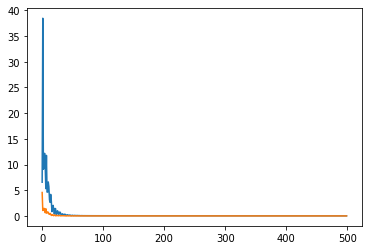

In [35]:

plt.plot(TRT_LOSS)
plt.plot(VAL_LOSS)
plt.show()

In [45]:
accumulated_test_loss = 0.0
net.reset_hidden_states(bs=1)
it_test = iter(data_loaded.test_dataloader)
c=0
while c < int(X_test.shape[0]/1):
    #net.eval()
    with torch.set_grad_enabled(False):
        #print(c)
        c = c+1
        item = next(it_test)
        outputs = net(item[0])
        accumulated_test_loss = accumulated_test_loss + criterion(outputs, item[1])        
print(accumulated_test_loss)

tensor(0.0186, dtype=torch.float64)


In [37]:
import pandas as pd

In [38]:
#os.mkdir('RESULTS_LOSS')

In [39]:
tr_loss_array = []
for z in TR_LOSS:
    tr_loss_array.append(z.tolist())
training_loss = pd.DataFrame(tr_loss_array, columns=['TR_LOSS'])
training_loss.to_csv('../RESULTS_LOSS/TR_LOSS_'+str(output_cardinality)+'.csv')

In [40]:
val_loss_array = []
for z in VAL_LOSS:
    val_loss_array.append(z.tolist())
val_loss = pd.DataFrame(val_loss_array, columns=['VAL_LOSS'])
val_loss.to_csv('../RESULTS_LOSS/VAL_LOSS_'+str(output_cardinality)+'.csv')

In [41]:
test_loss_array = [accumulated_test_loss] #mse
test2_loss = pd.DataFrame(test_loss_array, columns=['TEST_LOSS'])
test2_loss.to_csv('../RESULTS_LOSS/TEST_LOSS_'+str(output_cardinality)+'.csv')

In [42]:
# SAVE THE SCALER
import joblib
scaler_filename = "../SCALER_DUMPS/min_max_scaler_lookahead"+str(output_cardinality)+".save"
joblib.dump(scaler, scaler_filename) 
# And now to load...


['../SCALER_DUMPS/min_max_scaler_lookahead1.save']

In [43]:
#SAVE MODEL
model_ckp_path = "../MODEL_CHECKPOINTS/model_lookahead"+str(output_cardinality)+".pth" 
torch.save(net.state_dict(), model_ckp_path)

In [44]:
#net2 = LSTMNET(batch_size=batch_size,input_len=input_cardinality,output_len=output_cardinality)
#net2.load_state_dict(torch.load(model_ckp_path))
#net2.eval()
#scaler = joblib.load(scaler_filename) 